# Benchmarking Classical vs Genetic Neural Networks

This notebook benchmarks classical feed-forward fully connected neural networks against networks using GeneticLayer on several classification datasets from scikit-learn, including complex ones like Olivetti faces and forest cover types.

## 1. Setup

In [1]:
%load_ext autoreload
%autoreload 2

### 1.1 Imports

In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import (
    fetch_covtype,
    fetch_olivetti_faces,
    load_breast_cancer,
    load_digits,
    load_iris,
    load_wine,
    make_classification,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from utils.network_factory import (
    create_feedforward_classical_network,
    create_feedforward_genetic_network,
    create_heads_classical_network,
    create_heads_genetic_network,
)
from utils.plotting_utils import (
    plot_architecture_comparison,
    plot_bal_acc_vs_params,
)
from utils.summary_utils import create_summary_table
from utils.trainer_utils import train_and_evaluate

logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)

### 1.2 Data Loading and Preprocessing

In [3]:
# Load and preprocess datasets
datasets = {
    "digits": load_digits(),
    "iris": load_iris(),
    "wine": load_wine(),
    "breast_cancer": load_breast_cancer(),
    "synthetic": make_classification(
        n_samples=1500,
        n_features=50,
        n_informative=30,
        n_redundant=10,
        n_classes=7,
        random_state=42,
    ),
    "covtype": fetch_covtype(),
    "olivetti": fetch_olivetti_faces(),
}

processed_datasets = {}
for name, data in datasets.items():
    if isinstance(data, tuple):  # For synthetic dataset
        X, y = data
    elif name == "covtype":
        X, y = data["data"][:10000], data["target"][:10000]  # Use a subset for speed
    else:
        X, y = data.data, data.target
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=8080
    )
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)
    train_loader = DataLoader(
        train_ds, batch_size=2**14, shuffle=True, num_workers=8, persistent_workers=True
    )
    test_loader = DataLoader(
        test_ds, batch_size=2**14, num_workers=8, persistent_workers=True
    )
    processed_datasets[name] = {
        "input_size": X.shape[1],
        "output_size": len(np.unique(y)),
        "train_loader": train_loader,
        "val_loader": test_loader,
    }

## 2. Model Configuration

In [4]:
# Define architectures and their parameters
architectures = ["feedforward", "heads"]
network_types = ["classical", "genetic"]
# For feedforward: depth, for heads: n_heads
architecture_params = {
    "feedforward": [2, 4, 6],  # depths
    "heads": [1, 2, 3],  # n_heads
}
max_epochs = 128
results = {}

## 3. Training

In [5]:
# Train networks for each dataset, architecture, network type, and parameter
total_combinations = (
    len(processed_datasets)
    * len(architectures)
    * len(network_types)
    * len(architecture_params["feedforward"])
)
pbar = tqdm(total=total_combinations, desc="Training combinations")

for dataset_name, data in processed_datasets.items():
    input_size = data["input_size"]
    output_size = data["output_size"]
    train_loader = data["train_loader"]
    val_loader = data["val_loader"]

    for arch in architectures:
        params = architecture_params[arch]
        for net_type in network_types:
            for param in params:
                # Create the appropriate network
                if arch == "feedforward" and net_type == "classical":
                    model = create_feedforward_classical_network(
                        input_size, param, output_size
                    )
                elif arch == "heads" and net_type == "classical":
                    model = create_heads_classical_network(
                        input_size, param, output_size
                    )
                elif arch == "feedforward" and net_type == "genetic":
                    model = create_feedforward_genetic_network(
                        input_size, param, output_size
                    )
                elif arch == "heads" and net_type == "genetic":
                    model = create_heads_genetic_network(input_size, param, output_size)
                else:
                    raise ValueError("Unknown architecture or network type")

                # Train and evaluate
                metrics = train_and_evaluate(
                    model, train_loader, val_loader, max_epochs=max_epochs
                )
                results[f"{dataset_name}_{arch}_{net_type}_{param}"] = metrics
                pbar.update(1)

pbar.close()

Training combinations:   0%|          | 0/84 [00:00<?, ?it/s]

### 3.1. Create and Display Summary Table

In [6]:
summary_df = create_summary_table(results, processed_datasets)
summary_df.to_csv("artefacts/summary_table.csv", index=False)
display(summary_df)

,Dataset,Architecture,Network_Type,Parameter,Final_Bal_Acc,Best_Bal_Acc,Epochs_Trained,Num_Params,Training_Time,Param_Time_Ratio,Bal_Acc_Param_Ratio
36,breast_cancer,feedforward,classical,2,0.981899,0.981899,129,2242,2.283953,981.631429,0.000438
37,breast_cancer,feedforward,classical,4,0.981899,0.981899,129,10818,2.636418,4103.295278,0.000091
38,breast_cancer,feedforward,classical,6,0.992537,0.992537,129,19394,2.595624,7471.806480,0.000051
39,breast_cancer,feedforward,genetic,2,0.938234,0.956335,129,3014,2.815482,1070.509366,0.000311
40,breast_cancer,feedforward,genetic,4,0.841219,0.851858,129,6246,3.235142,1930.672599,0.000135
...,...,...,...,...,...,...,...,...,...,...,...
31,wine,heads,classical,2,0.969697,0.969697,129,1091,2.319406,470.379047,0.000889
32,wine,heads,classical,3,0.969697,0.969697,129,1635,2.281264,716.707984,0.000593
33,wine,heads,genetic,1,0.939394,0.939394,129,1165,2.831931,411.380098,0.000806
34,wine,heads,genetic,2,0.969697,0.969697,129,2931,2.857990,1025.545916,0.000331


## 4. Results

### 4.1. Plotting

#### 4.1.1. Plotting Balanced Accuracy Over Epochs for All Models on All Datasets

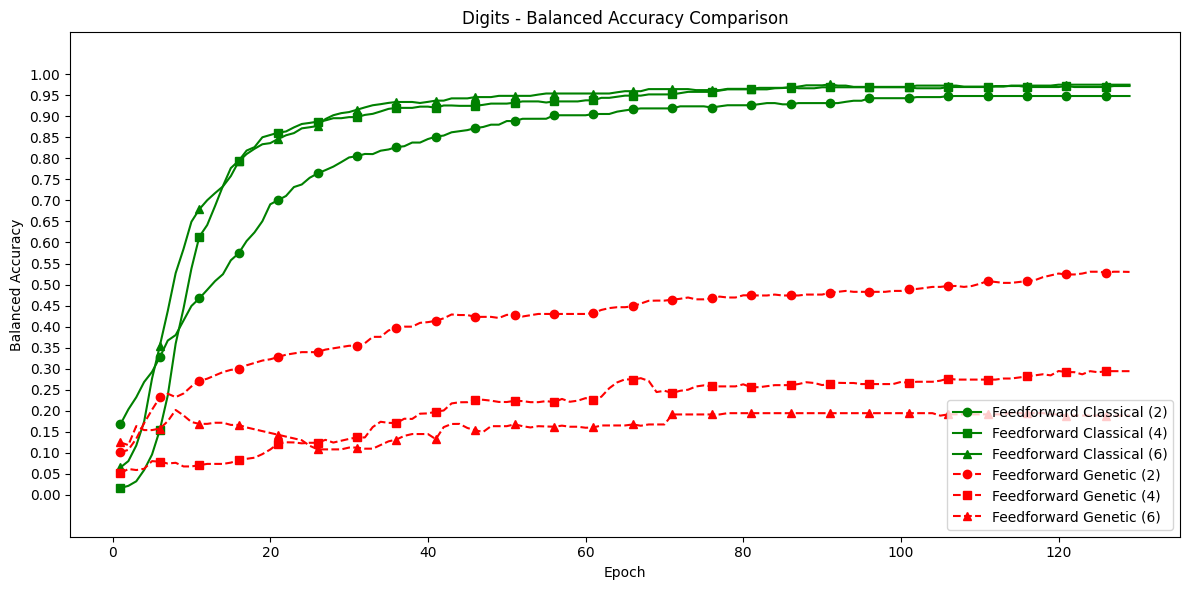

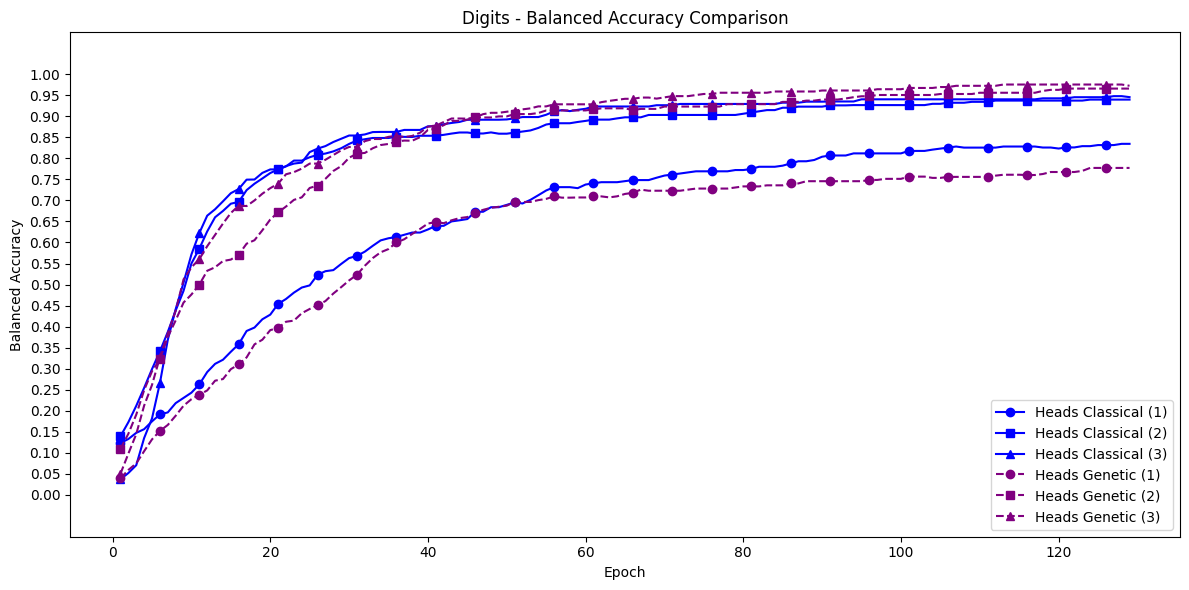

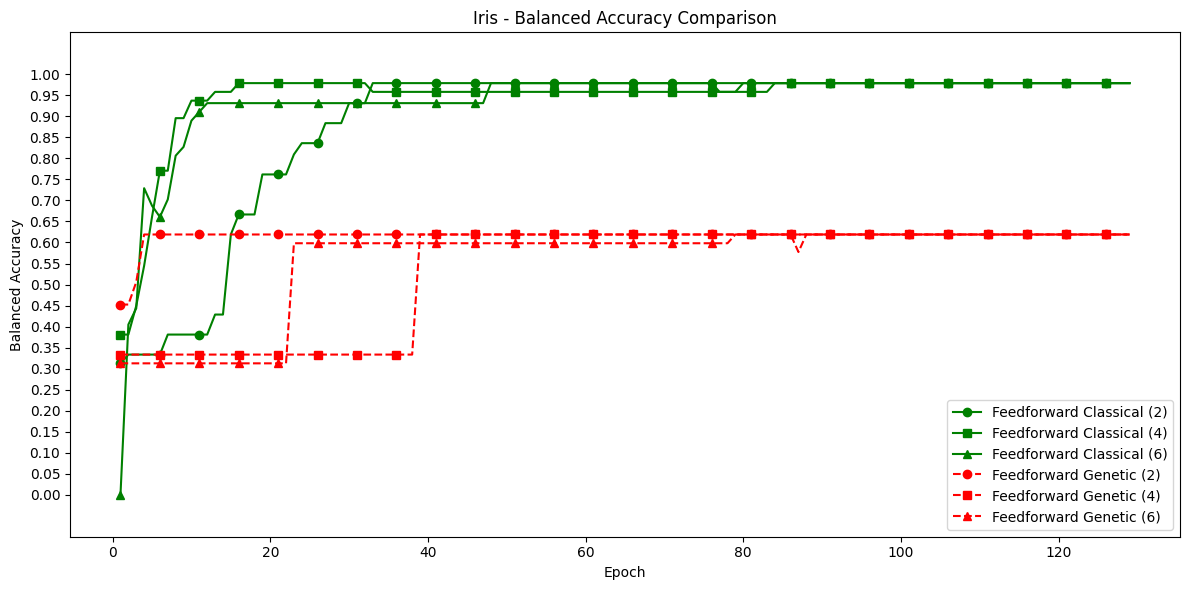

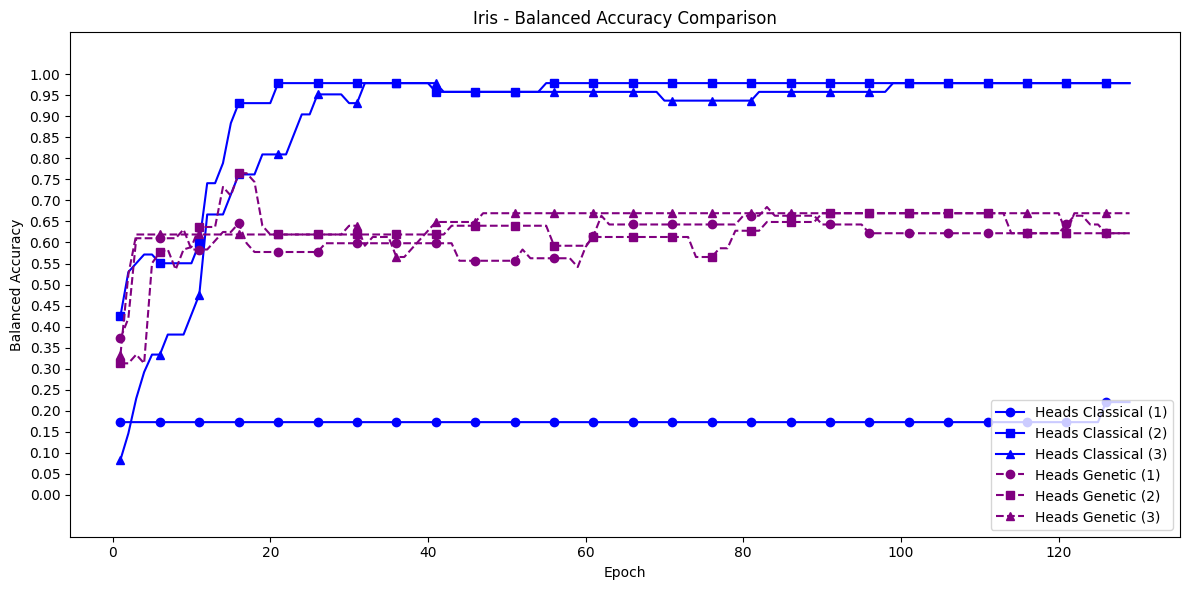

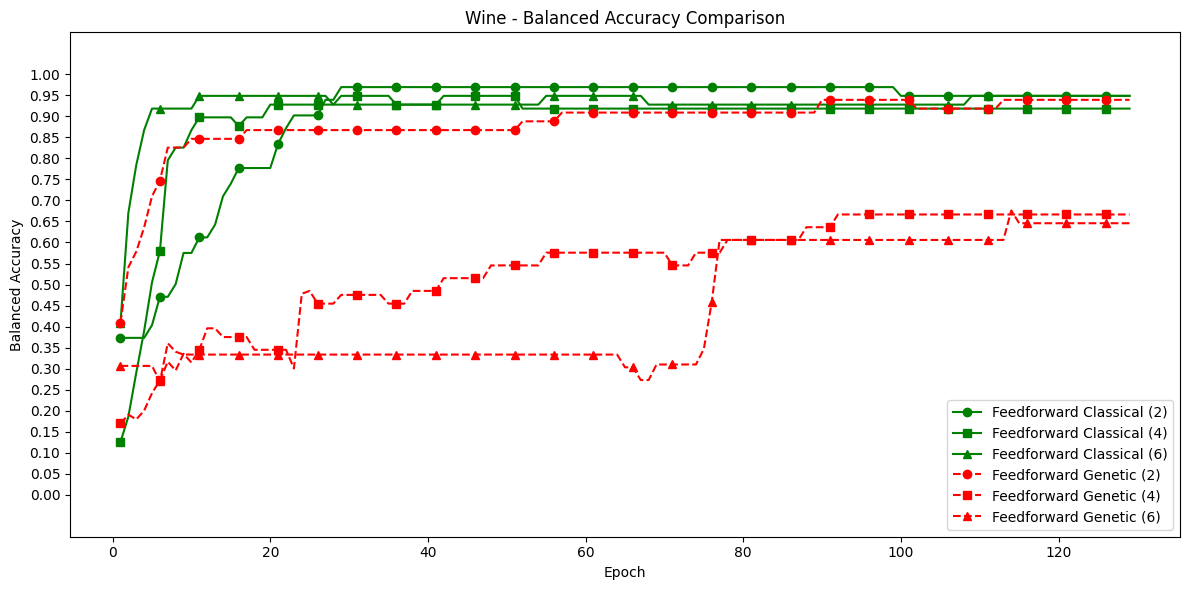

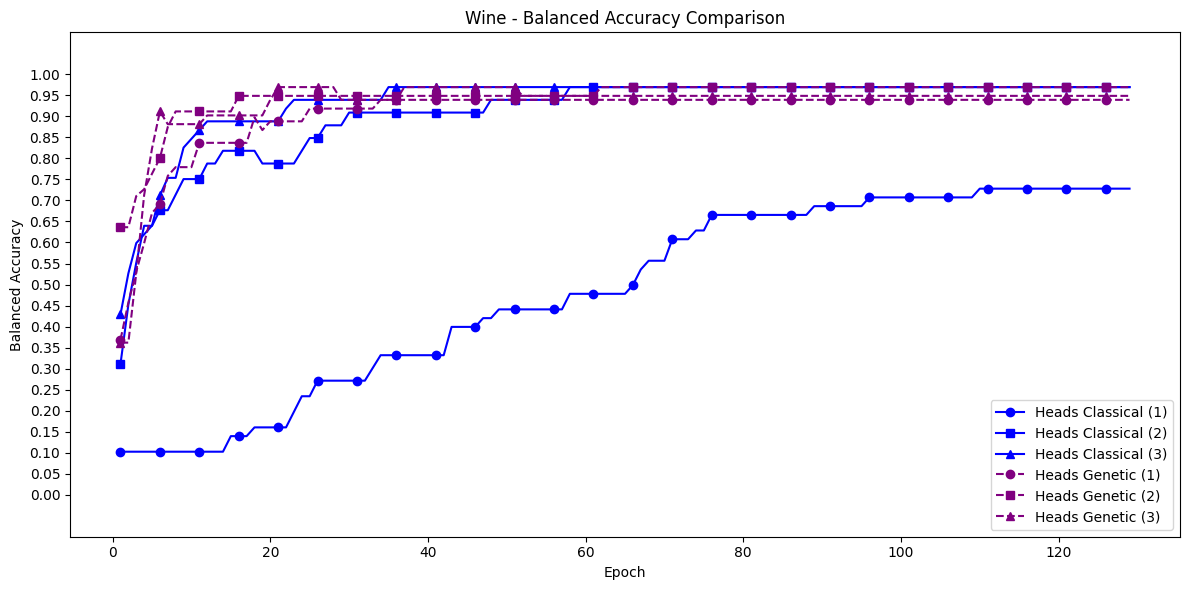

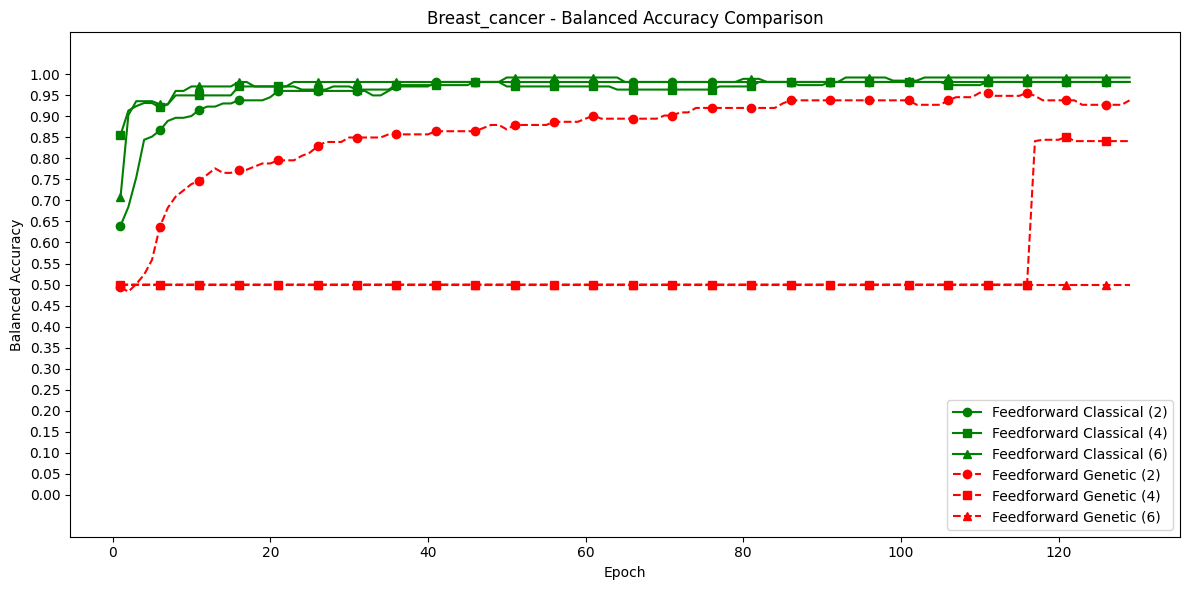

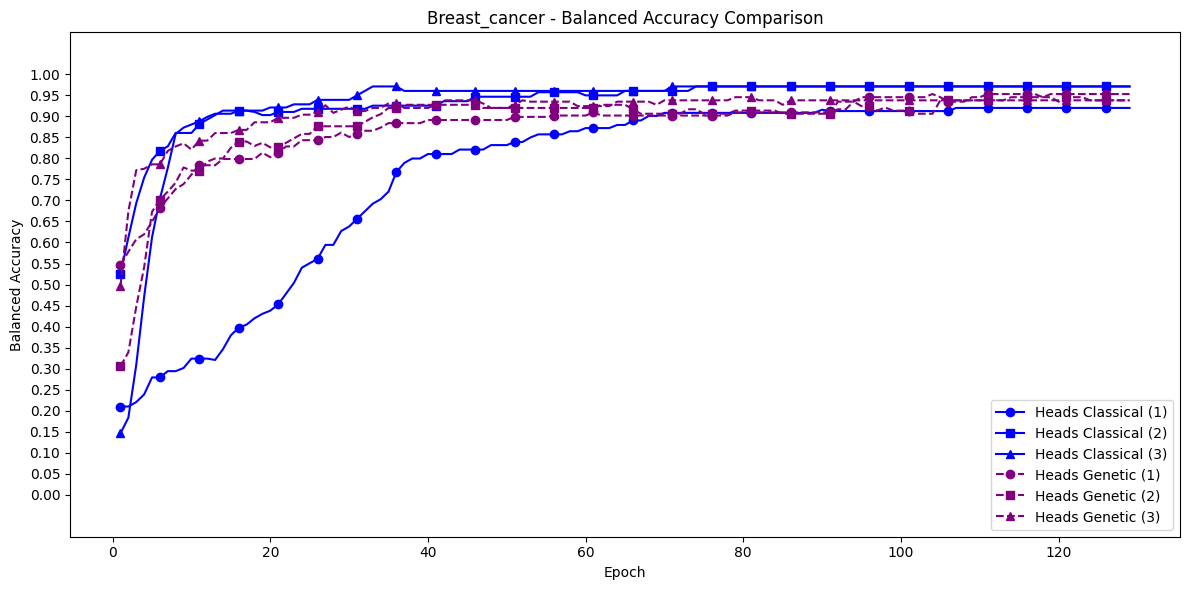

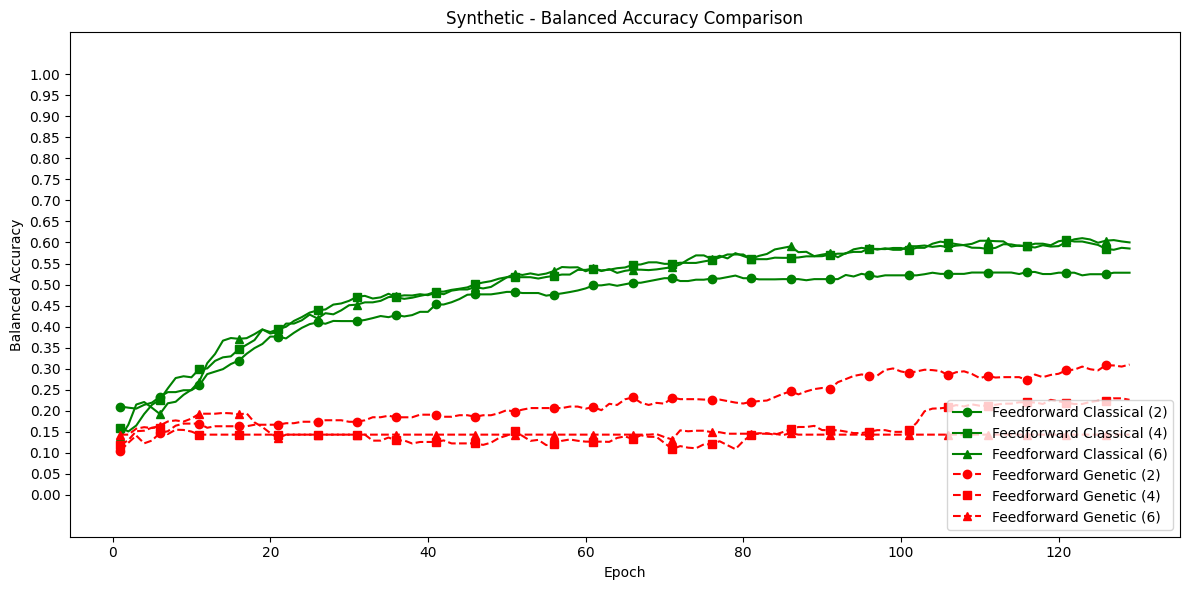

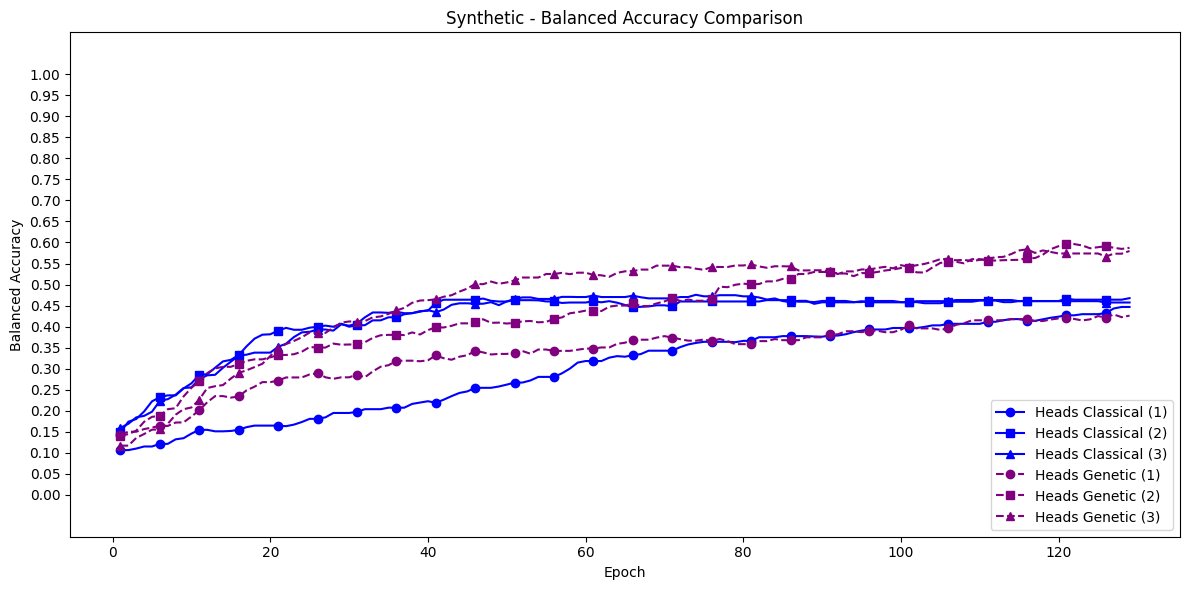

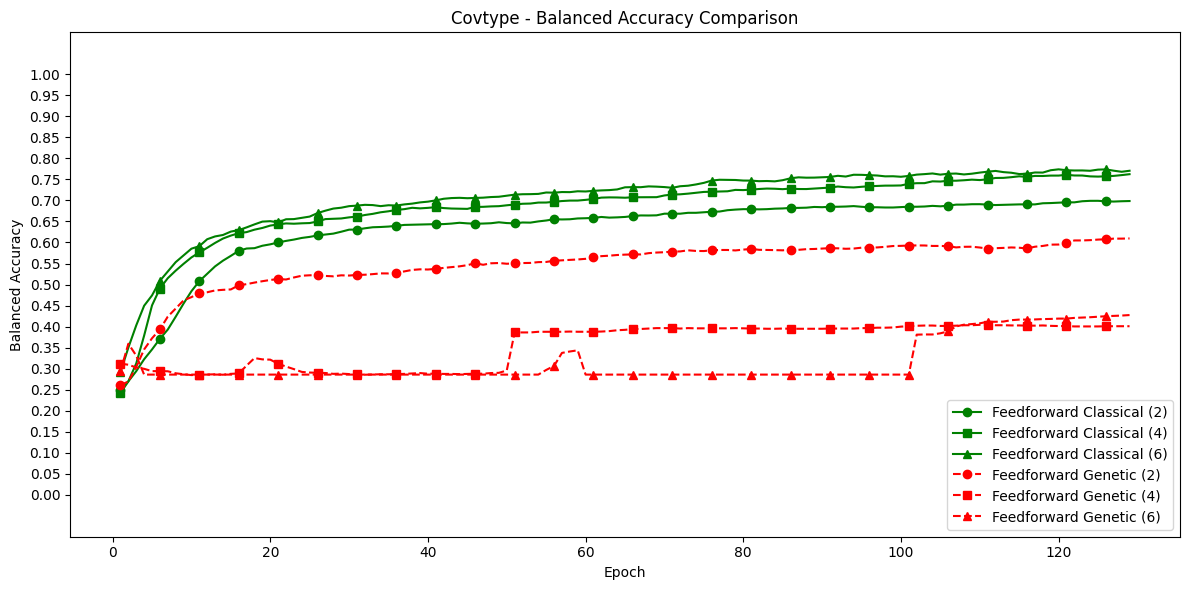

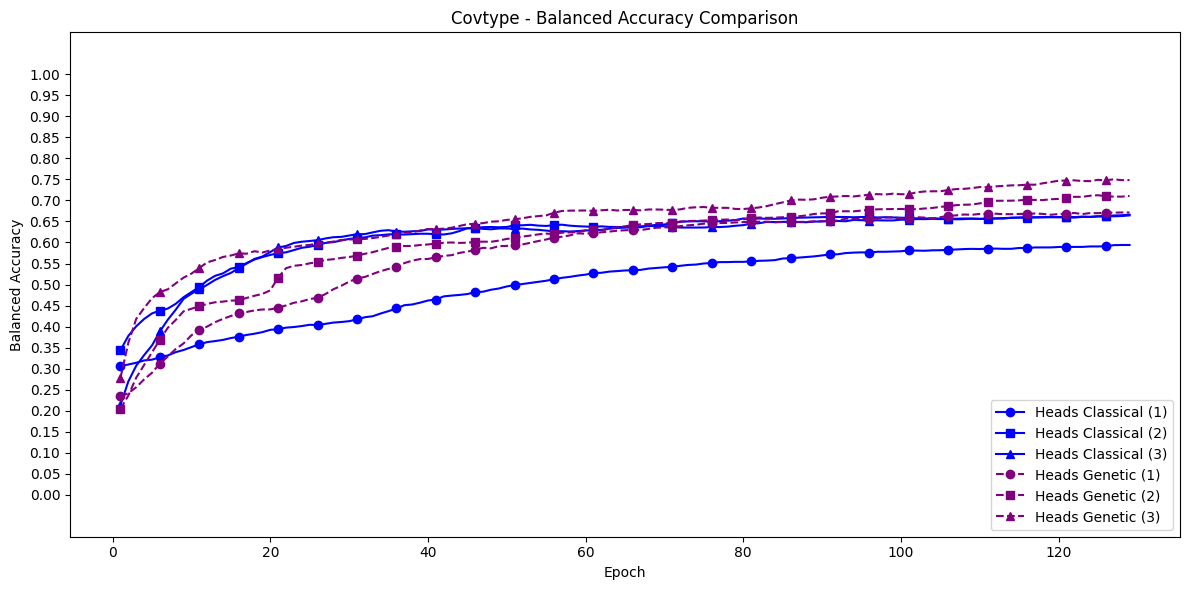

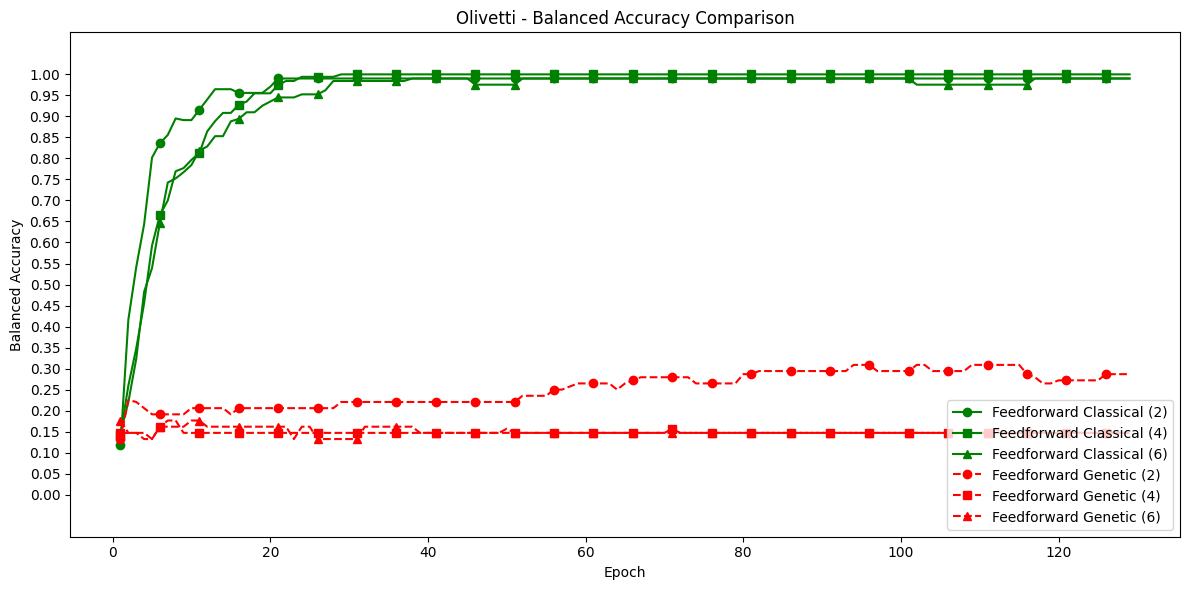

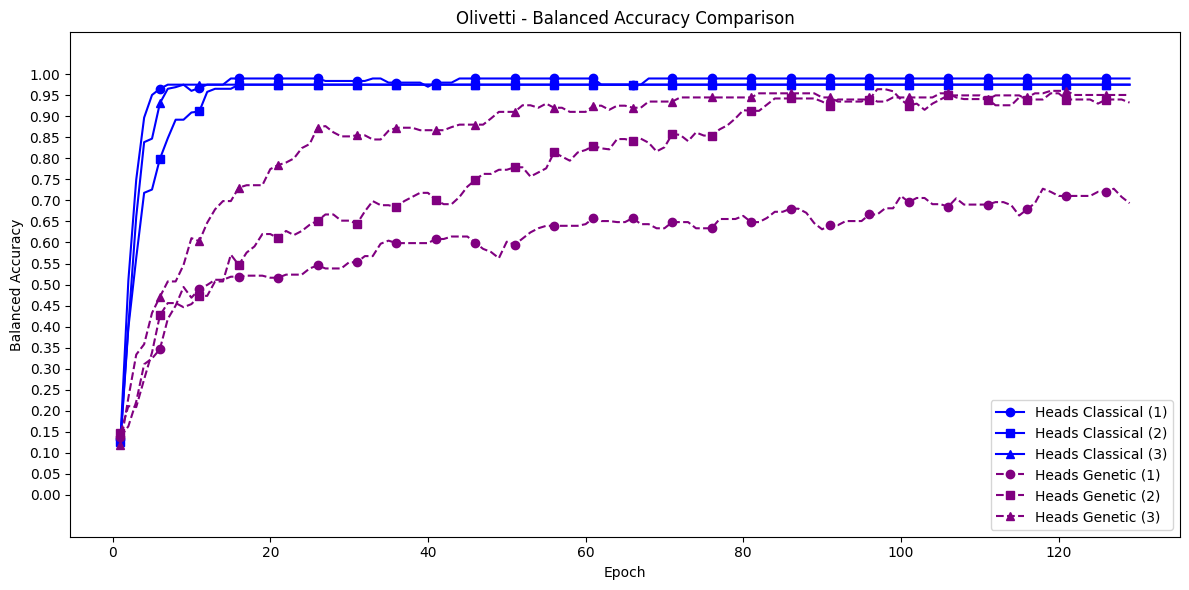

In [7]:
datasets_list = list(processed_datasets.keys())

# Define all architecture combinations for plotting
architecture_combinations = []
for arch in architectures:
    for net_type in network_types:
        for param in architecture_params[arch]:
            architecture_combinations.append(f"{arch}_{net_type}")

# Plot balanced accuracy comparison for each dataset
for dataset in datasets_list:
    # Plot for feedforward architectures
    feedforward_archs = [f"feedforward_{net_type}" for net_type in network_types]
    fig_ff = plot_architecture_comparison(
        results, dataset, feedforward_archs, architecture_params["feedforward"]
    )
    plt.savefig(f"artefacts/feedforward_comparison_{dataset}.png")
    plt.show()

    # Plot for heads architectures
    heads_archs = [f"heads_{net_type}" for net_type in network_types]
    fig_heads = plot_architecture_comparison(
        results, dataset, heads_archs, architecture_params["heads"]
    )
    plt.savefig(f"artefacts/heads_comparison_{dataset}.png")
    plt.show()

#### 4.1.2. Plotting Balanced Accuracy vs Number of Parameters for All Models on All Datasets

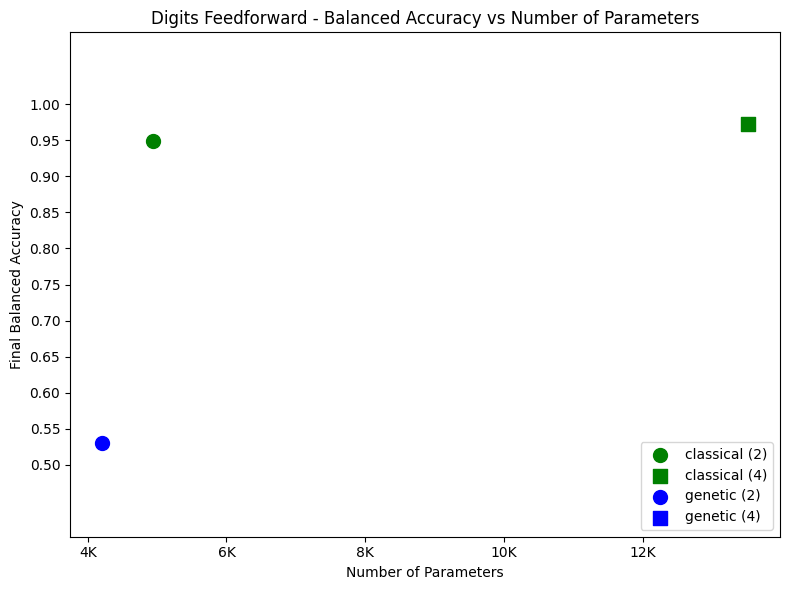

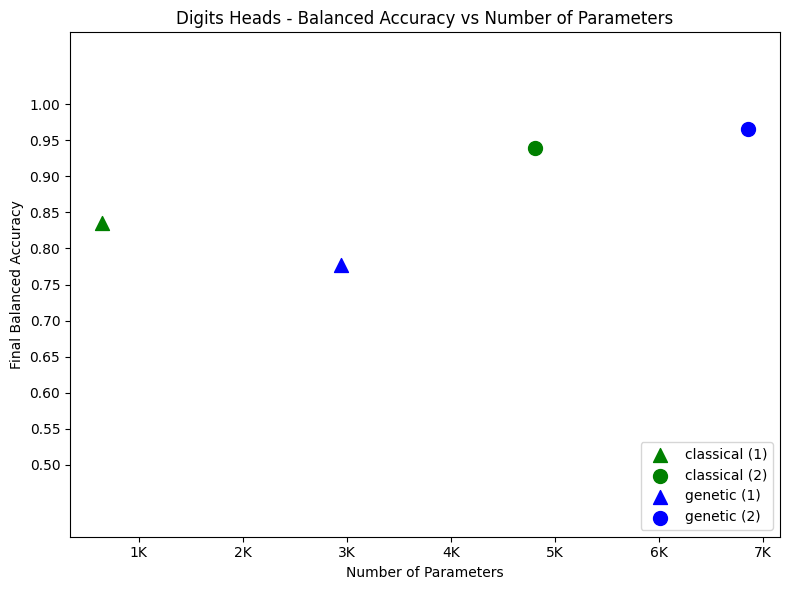

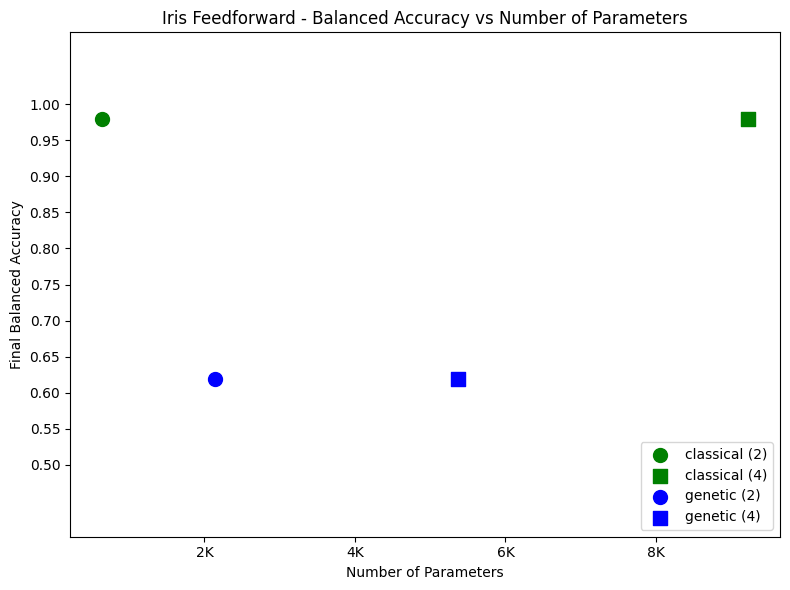

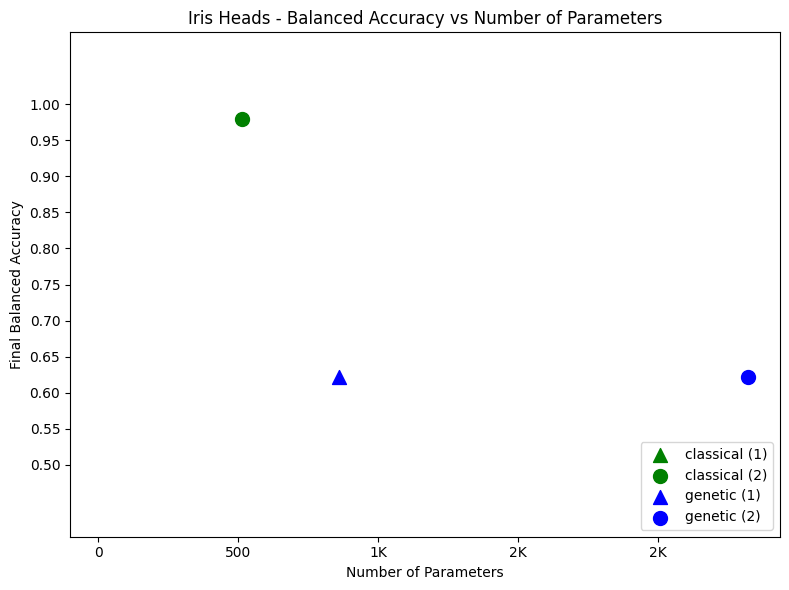

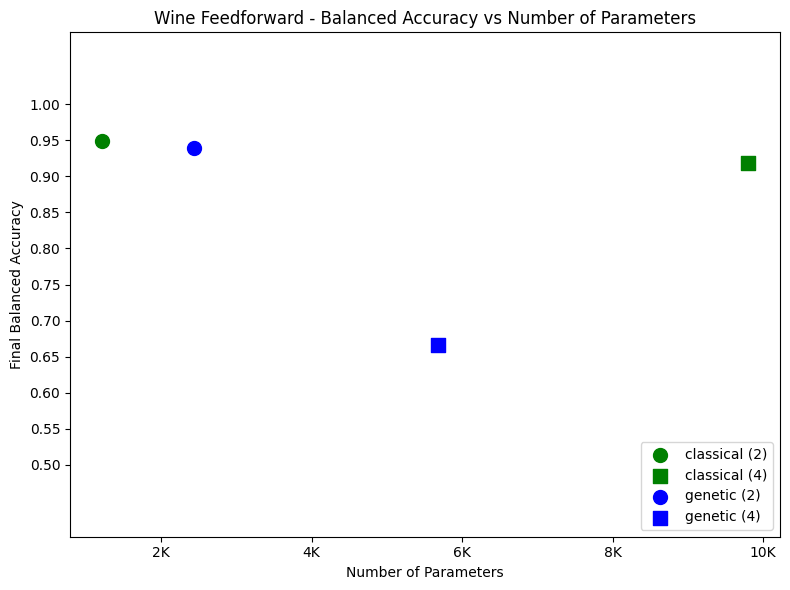

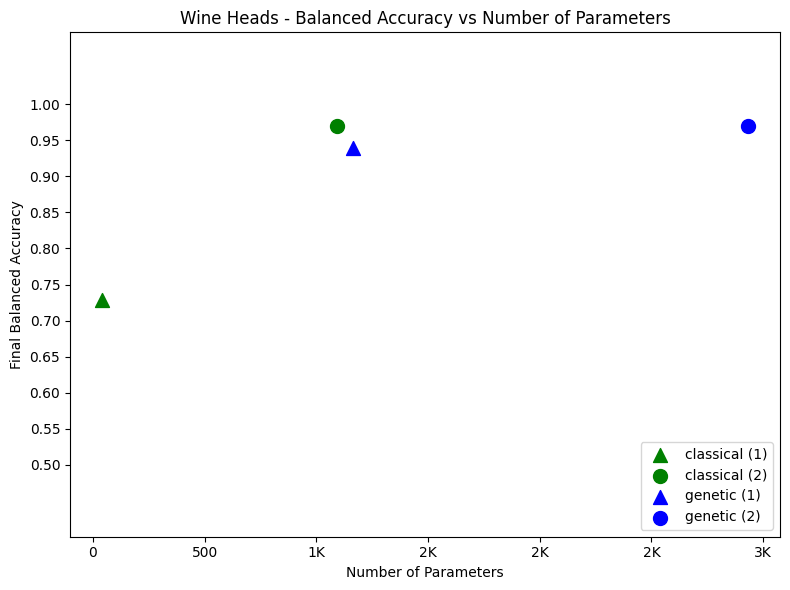

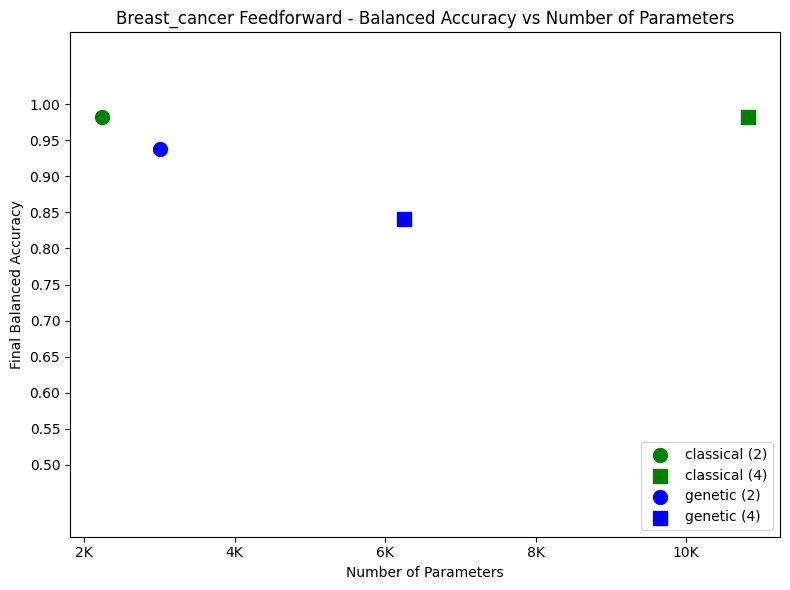

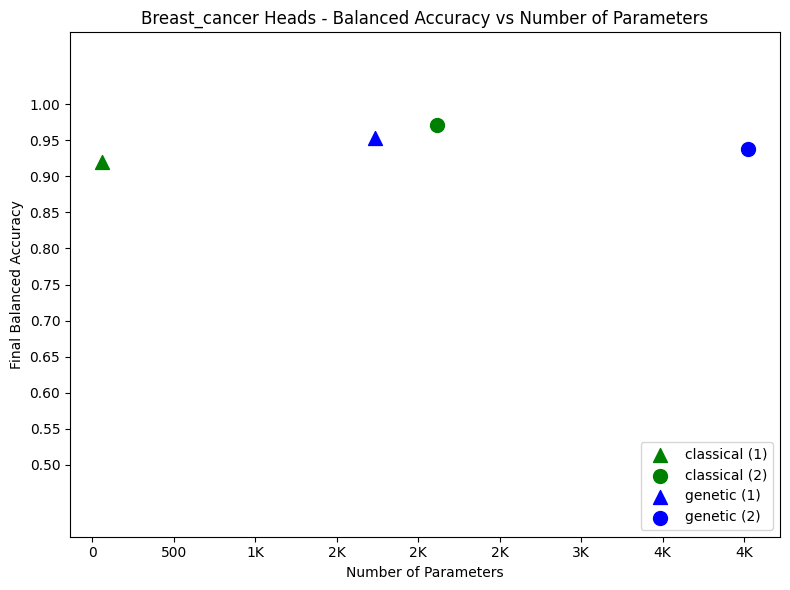

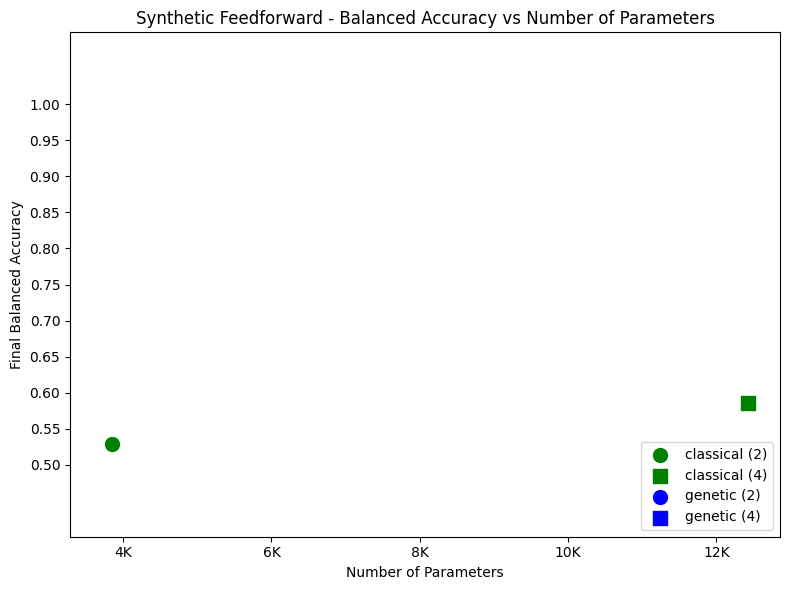

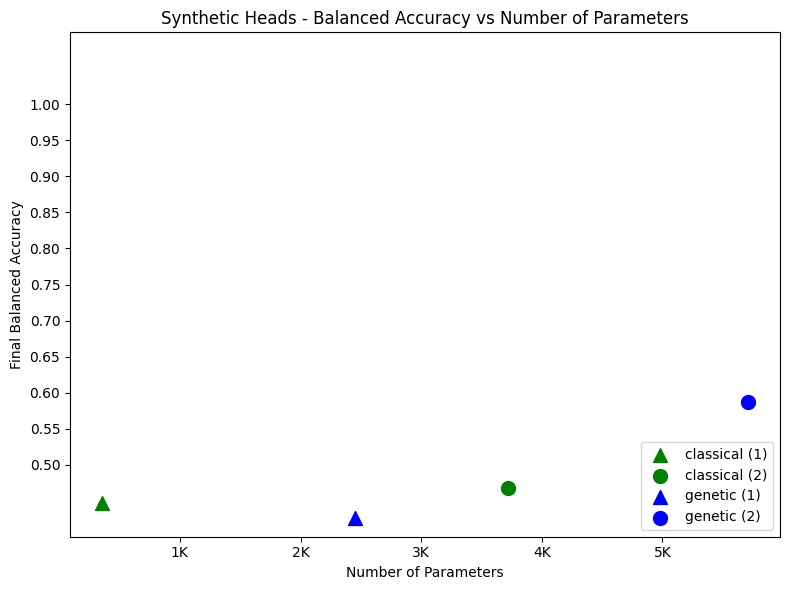

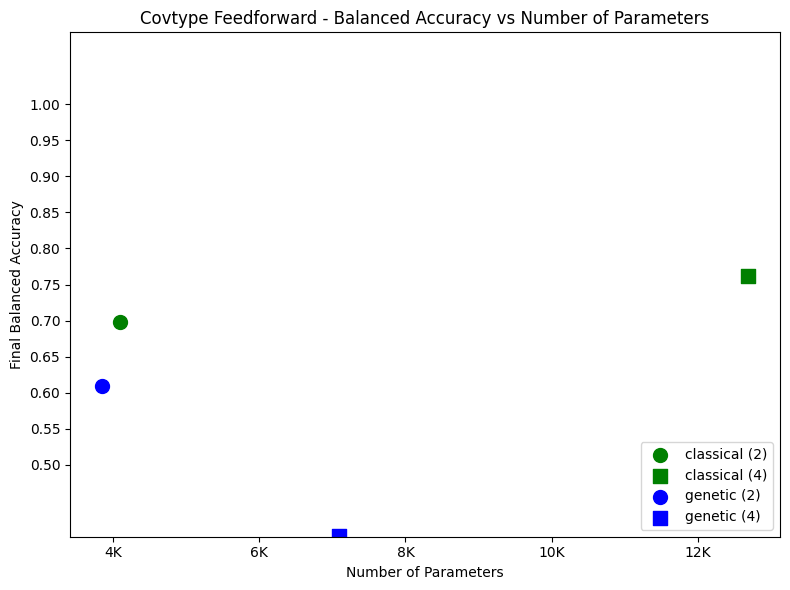

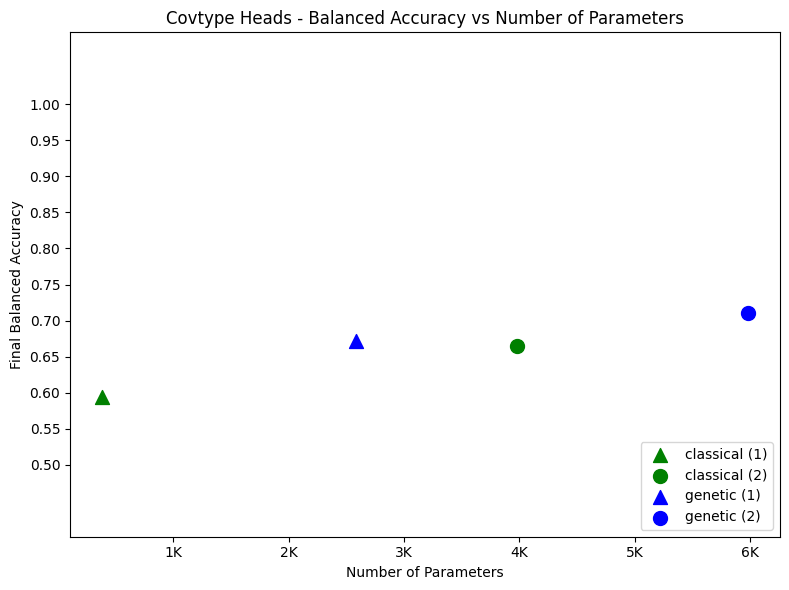

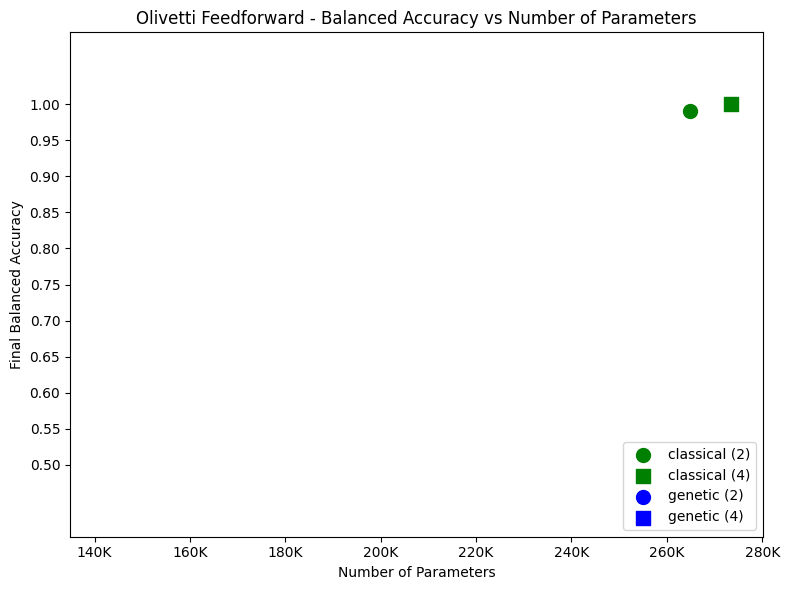

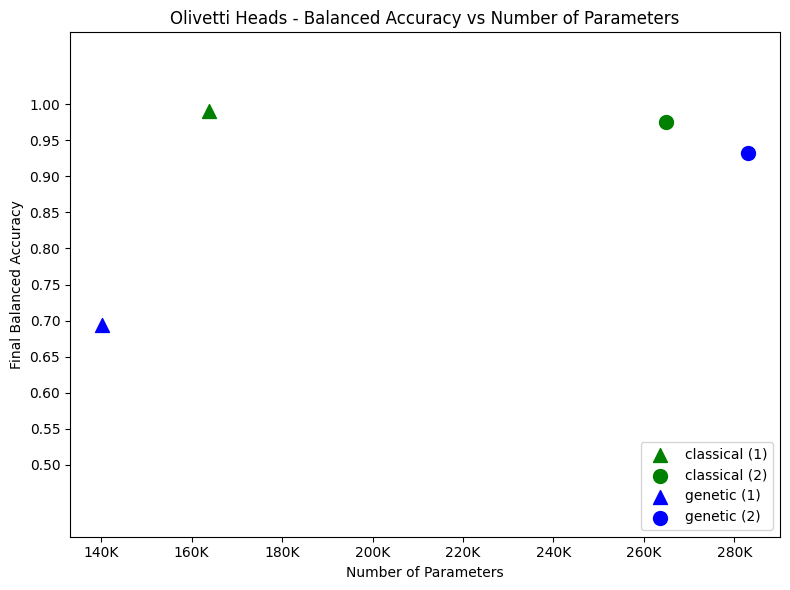

In [8]:
for dataset in datasets_list:
    for arch in ["feedforward", "heads"]:
        plot_bal_acc_vs_params(
            results,
            dataset,
            arch,
            save_path=f"artefacts/bal_acc_vs_params_{dataset}_{arch}.png",
        )